Init za spark

In [ ]:
!pip install pyspark py4j

In [ ]:
# init koji ne radi
# # Instaliraj Spark
# !apt-get install openjdk-8-jdk-headless -qq > /dev/null
# !wget -q https://archive.apache.org/dist/spark/spark-3.5.0/spark-3.5.0-bin-hadoop3.tgz
# !tar xf spark-3.5.0-bin-hadoop3.tgz

# # Podesi environment varijable
# import os
# os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
# os.environ["SPARK_HOME"] = "/content/spark-3.5.0-bin-hadoop3"

# # Instaliraj findspark
# !pip install findspark

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, FloatType, BooleanType
from pyspark.sql.functions import col, sum, lit, round, when, regexp_extract
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

spark = SparkSession.builder.appName("SteamAnalysis").getOrCreate()

print("Spark sesija je aktivna!")

Spark sesija je aktivna!


# Ucitavanje podataka

In [ ]:
# def seme
schema = StructType([
    StructField("AppID", StringType(), True),
    StructField("name", StringType(), True),
    StructField("releaseDate", StringType(), True),
    StructField("estimatedOwners", StringType(), True),   # npr "2000000 - 5000000"
    StructField("peakCCU", IntegerType(), True),
    StructField("required_age", IntegerType(), True),
    StructField("price", FloatType(), True),
    StructField("discount", FloatType(), True),
    StructField("dlcCount", IntegerType(), True),
    StructField("longDesc", StringType(), True),
    StructField("languages", StringType(), True),
    StructField("fullAudioLanguages", StringType(), True),
    StructField("reviews", StringType(), True),
    StructField("headerImage", StringType(), True),
    StructField("website", StringType(), True),
    StructField("supportWeb", StringType(), True),
    StructField("supportEmail", StringType(), True),
    StructField("supportWindows", BooleanType(), True),
    StructField("supportMac", BooleanType(), True),
    StructField("supportLinux", BooleanType(), True),
    StructField("metacriticScore", IntegerType(), True),
    StructField("metacriticURL", StringType(), True),
    StructField("userScore", IntegerType(), True),
    StructField("positive", IntegerType(), True),
    StructField("negative", IntegerType(), True),
    StructField("scoreRank", StringType(), True),
    StructField("achievements", IntegerType(), True),
    StructField("recommendations", IntegerType(), True),
    StructField("notes", StringType(), True),
    StructField("averagePlaytime", IntegerType(), True),
    StructField("averagePlaytime2W", IntegerType(), True),
    StructField("medianPlaytime", IntegerType(), True),
    StructField("medianPlaytime2W", IntegerType(), True),
    StructField("developers", StringType(), True),
    StructField("publishers", StringType(), True),
    StructField("categories", StringType(), True),
    StructField("genres", StringType(), True),
    StructField("tags", StringType(), True),
    StructField("screenshots", StringType(), True),
    StructField("movies", StringType(), True)
])

# file_name = '/content/stream_data_output.csv';
file_name = '/content/all_the_data.csv';

# ucitavanje csv
df = spark.read.csv(
    file_name,
    header=True,
    schema=schema,
    multiLine=True,
    escape="\""
)

print(f"Broj redova: {df.count()}")
df.show(5)

Broj redova: 76638
+-------+------------------------+------------+---------------+-------+------------+-----+--------+--------+----------------------+--------------------+------------------+-------+--------------------+--------------------+--------------------+--------------------+--------------+----------+------------+---------------+-------------+---------+--------+--------+---------+------------+---------------+--------------------+---------------+-----------------+--------------+----------------+--------------------+----------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|  AppID|                    name| releaseDate|estimatedOwners|peakCCU|required_age|price|discount|dlcCount|              longDesc|           languages|fullAudioLanguages|reviews|         headerImage|             website|          supportWeb|        supportEmail|supportWindows|supportMac|supportLinux|metacriticScore|metacriticURL|userScore|positive|

# Ciscenje podataka

In [ ]:
df_clean = df

# beskonacno null
columns_to_drop = ['metacriticURL', 'scoreRank', 'notes']
df_clean = df_clean.drop(*columns_to_drop)

# reviews u broj recenzija
df_clean = df_clean.withColumn(
    "review_count",
    when(col("reviews").isNull(), 0).otherwise(
        regexp_extract(col("reviews"), r"(\d+,?\d*)", 1)
    )
).drop("reviews")

# zamena zareza i konvertovanje u integer
df_clean = df_clean.withColumn(
    "review_count",
    when((col("review_count") == "") | (col("review_count").isNull()), 0)
    .otherwise(regexp_extract(col("review_count"), r"(\d+)", 1).cast("integer"))
)

# da li ima num s null
numeric_columns_for_cleaning = [
    'peakCCU', 'required_age', 'price', 'discount', 'dlcCount',
    'supportWindows', 'supportMac', 'supportLinux', 'metacriticScore',
    'userScore', 'positive', 'negative', 'achievements', 'recommendations',
    'averagePlaytime', 'averagePlaytime2W', 'medianPlaytime', 'medianPlaytime2W',
    'review_count'
]
df_clean = df_clean.fillna(0, subset=numeric_columns_for_cleaning)

# popunjavanja tekstualnih kolona
text_columns_to_fill = {
    'website': 'N/A',
    'supportWeb': 'N/A',
    'supportEmail': 'N/A',
    'longDesc': '',
    'developers': 'Unknown',
    'publishers': 'Unknown',
    'categories': 'Other',
    'genres': 'Other',
    'tags': 'None',
    'screenshots': '',
    'movies': ''
}


# prvo provera da li kolona postoji i da je string tipa
string_columns = [field.name for field in df_clean.schema.fields if isinstance(field.dataType, StringType)]

for column, fill_value in text_columns_to_fill.items():
    if column in string_columns:  # Popuni samo ako je string kolona
        df_clean = df_clean.fillna(fill_value, subset=[column])

# Provera null vrednosti
# print("Procenti null vrednosti nakon čišćenja:")
total_rows = df_clean.count()

for column in df_clean.columns:
    try:
        null_count = df_clean.filter(col(column).isNull()).count()
        percentage = (null_count / total_rows) * 100
        if null_count > 0:
            print(f"{column}: {null_count} null ({percentage:.2f}%)")
    except Exception as e:
        print(f"Greška pri proveri kolone {column}: {str(e)}")

# dodatna sigurnost: konverzija svih numeričkih kolona eksplicitno
for column in numeric_columns_for_cleaning:
    if column in df_clean.columns:
        df_clean = df_clean.withColumn(column, col(column).cast("double"))

print("\nČišćenje podataka završeno!")

for field in df_clean.schema.fields:
    print(f"🔹 {field.name:25} | {str(field.dataType):15} | Nullable: {field.nullable}")


Procenti null vrednosti nakon čišćenja:
name: 2 null (0.00%)

Čišćenje podataka završeno!
🔹 AppID                     | StringType()    | Nullable: True
🔹 name                      | StringType()    | Nullable: True
🔹 releaseDate               | StringType()    | Nullable: True
🔹 estimatedOwners           | StringType()    | Nullable: True
🔹 peakCCU                   | DoubleType()    | Nullable: True
🔹 required_age              | DoubleType()    | Nullable: True
🔹 price                     | DoubleType()    | Nullable: False
🔹 discount                  | DoubleType()    | Nullable: False
🔹 dlcCount                  | DoubleType()    | Nullable: True
🔹 longDesc                  | StringType()    | Nullable: False
🔹 languages                 | StringType()    | Nullable: True
🔹 fullAudioLanguages        | StringType()    | Nullable: True
🔹 headerImage               | StringType()    | Nullable: True
🔹 website                   | StringType()    | Nullable: False
🔹 supportWeb            

Kratko objašnjenje podataka

Podaci predstavljaju Steam igre i njihove karakteristike, uključujući informacije o cenama, preporukama, ocenama kritičara i korisnika, broju igrača, vremenu igranja, podržanim platformama, žanrovima, dostignućima i drugim atributima. Dataset sadrži ~70.000 igara.

### Kratko objašnjenje čišćenja podataka

Uklanjanje nepotrebnih kolona – kolone koje nisu relevantne ili imaju previše null vrednosti (metacriticURL, scoreRank, notes) su uklonjene.

Obrada recenzija – kolona reviews je transformisana u numeričku kolonu review_count koja predstavlja broj recenzija, uz zamenu praznih vrednosti sa 0 i konverziju u integer.

Popunjavanje numeričkih kolona – numeričke kolone sa null vrednostima su popunjene sa 0.

Popunjavanje tekstualnih kolona – za string kolone null vrednosti su zamenjene logičnim default vrednostima (npr. Unknown, N/A, Other), a samo za postojeće string kolone.

Konverzija tipova – sve numeričke kolone su eksplicitno konvertovane u double, čime se obezbeđuje konzistentnost tipova podataka.

Provera null vrednosti – nakon čišćenja provereno je da li još uvek postoje null vrednosti i njihov procenat, kako bi se osigurala pouzdanost analize.

Rezultat: Dataset je očišćen, konzistentan i spreman za dalju analizu i modele predikcije.



1. TEST: KORELACIJA

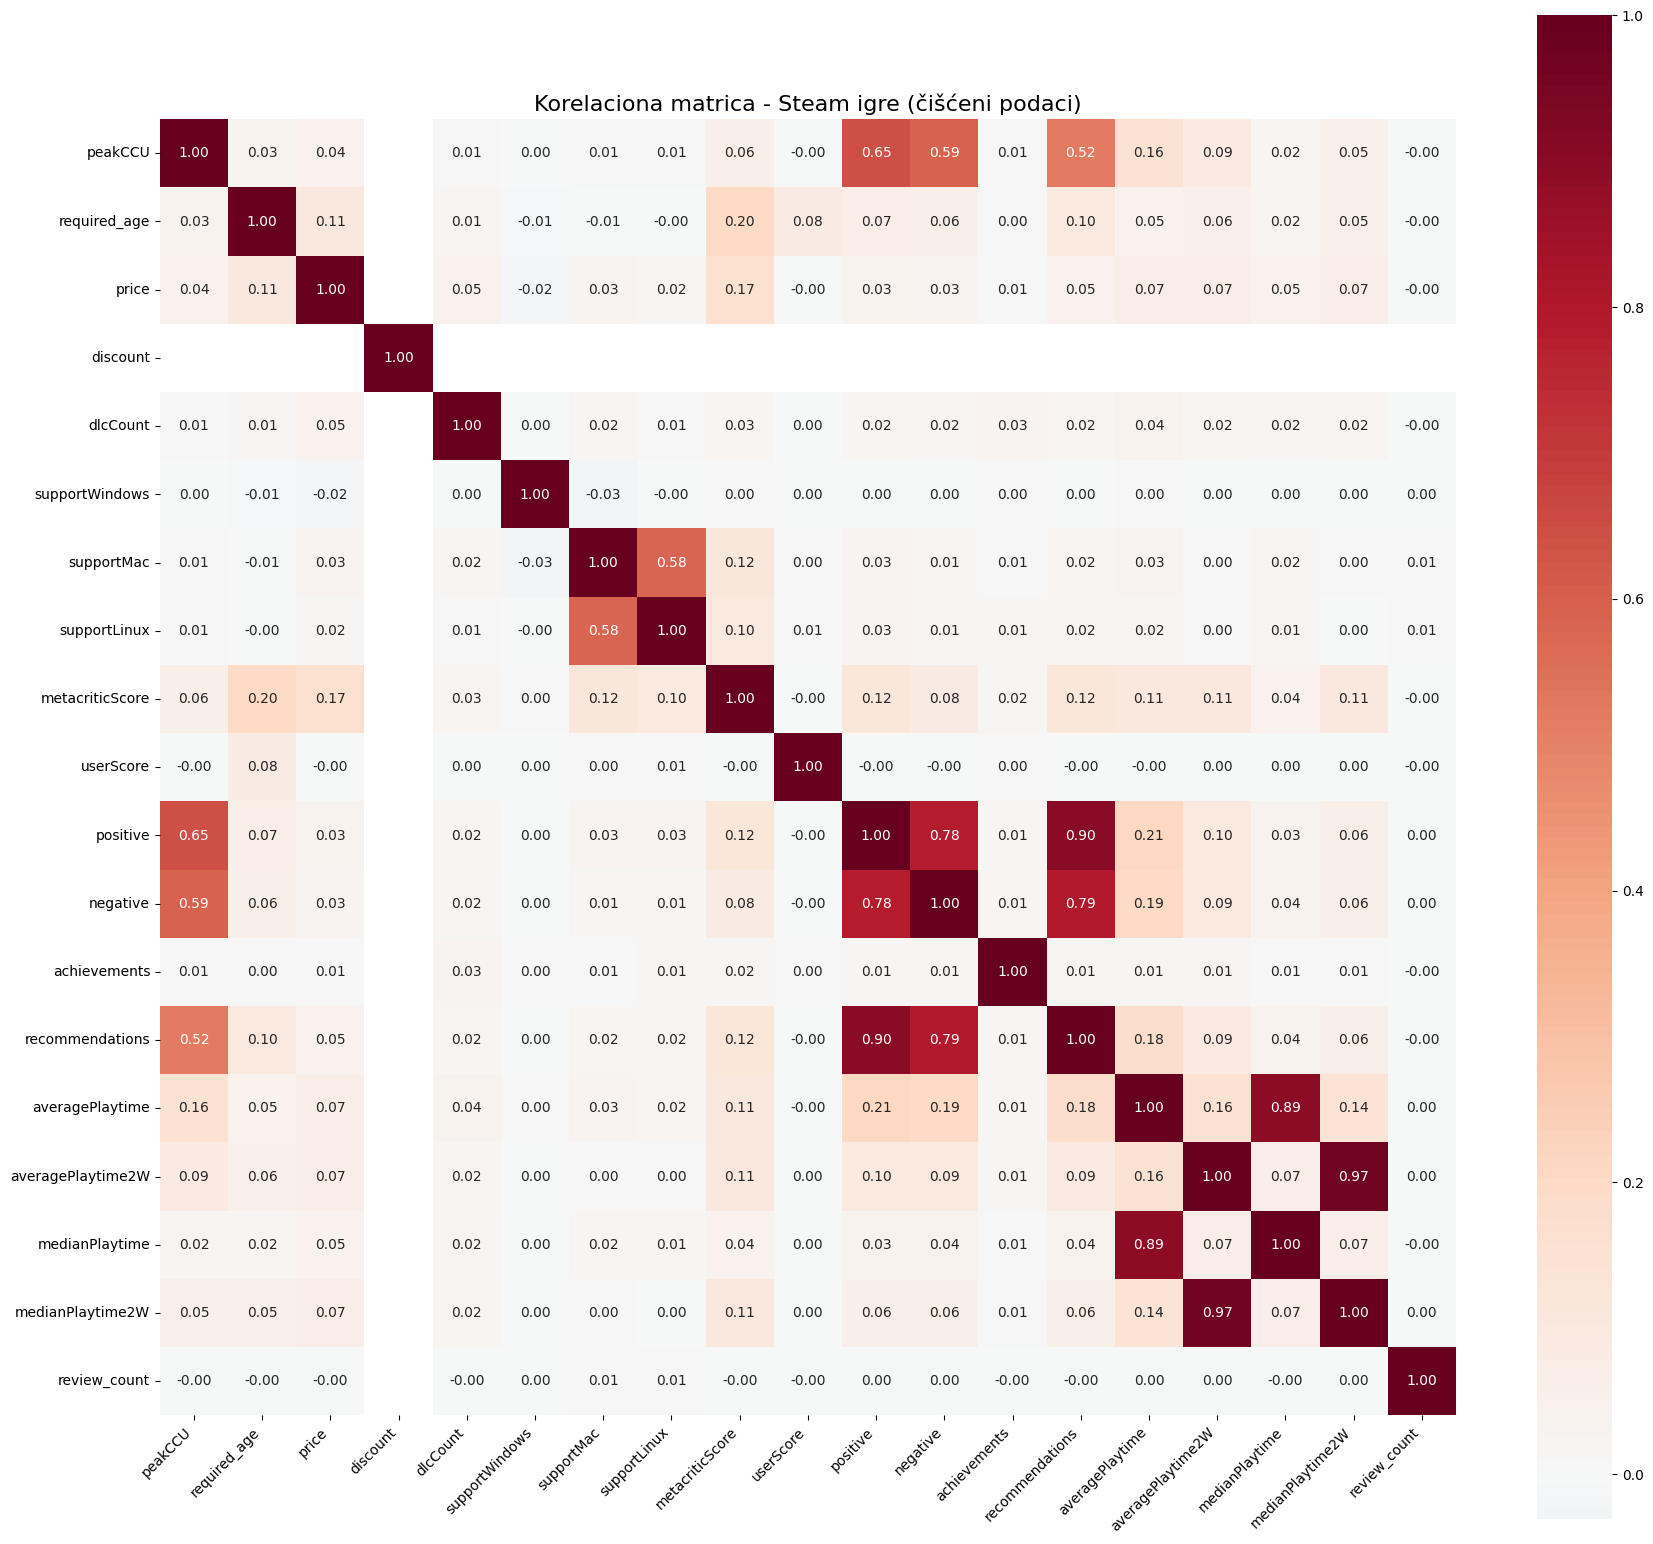

None

In [ ]:
numeric_columns = [
    'peakCCU', 'required_age', 'price', 'discount', 'dlcCount',
    'supportWindows', 'supportMac', 'supportLinux', 'metacriticScore',
    'userScore', 'positive', 'negative', 'achievements', 'recommendations',
    'averagePlaytime', 'averagePlaytime2W', 'medianPlaytime', 'medianPlaytime2W',
    'review_count'
]

df_clean = df_clean.fillna(0, subset=numeric_columns)

assembler = VectorAssembler(inputCols=numeric_columns, outputCol="features")
df_vector = assembler.transform(df_clean).select("features")

# korelaciona mat
correlation_matrix = Correlation.corr(df_vector, "features").head()
corr_array = correlation_matrix[0].toArray()

# vizuelizacija
corr_df = pd.DataFrame(corr_array, columns=numeric_columns, index=numeric_columns)

plt.figure(figsize=(18, 16))
sns.heatmap(corr_df, annot=True, cmap="RdBu_r", center=0, square=True, fmt=".2f")
plt.title('Korelaciona matrica - Steam igre (čišćeni podaci)', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
display(plt.show())


- **Najbolji pokazatelji popularnosti igre** su peakCCU, positive, negative i recommendations, jer su međusobno snažno povezani.
- **User score i metacritic score** se razlikuju i ne prate jedno drugo, što bi bilo zanimljivo za dodatnu analizu.
- Cena i podrška za različite platforme imaju tek slab uticaj na ostale metrike.

# 2. TEST: Besplatne vs. plaćene igre (t-test)
Hipoteza: Besplatne igre imaju značajno veći broj igrača i recenzija od plaćenih igara.

In [ ]:
from pyspark.sql.functions import when, col
from scipy.stats import ttest_ind
import pandas as pd

# dodaj kolonu 'is_free'
df_test1 = df_clean.withColumn("is_free", when(col("price") == 0, 1).otherwise(0))

pdf_test1 = df_test1.select("is_free", "peakCCU", "positive", "recommendations", "review_count").toPandas()

# podela na grupe
free_games = pdf_test1[pdf_test1["is_free"] == 1]
paid_games = pdf_test1[pdf_test1["is_free"] == 0]

# kolone koje testiram
cols_to_test = ["peakCCU", "positive", "recommendations", "review_count"]

results = []
for col_name in cols_to_test:
    t_stat, p_val = ttest_ind(free_games[col_name], paid_games[col_name], equal_var=False, nan_policy='omit')
    results.append({
        "Metric": col_name,
        "Free_Mean": free_games[col_name].mean(),
        "Paid_Mean": paid_games[col_name].mean(),
        "t-stat": t_stat,
        "p-value": p_val
    })

results_df = pd.DataFrame(results)
print("Rezultati t-testa (besplatne vs. plaćene igre):")
display(results_df)


Rezultati t-testa (besplatne vs. plaćene igre):


,Metric,Free_Mean,Paid_Mean,t-stat,p-value
0,peakCCU,337.076548,71.583980,1.925815,0.054164
1,positive,2301.351455,1133.506336,1.458470,0.144751
2,recommendations,932.611232,1080.096690,-0.296380,0.766947
3,review_count,128499.242980,19001.837813,0.845309,0.397963


# 2.5 TEST: Skupije igre sa više achievementa i popularnost
Hipoteza: Igre koje imaju višu cenu i više achievementa dobijaju više pozitivnih ocena i igraju se duže (averagePlaytime).

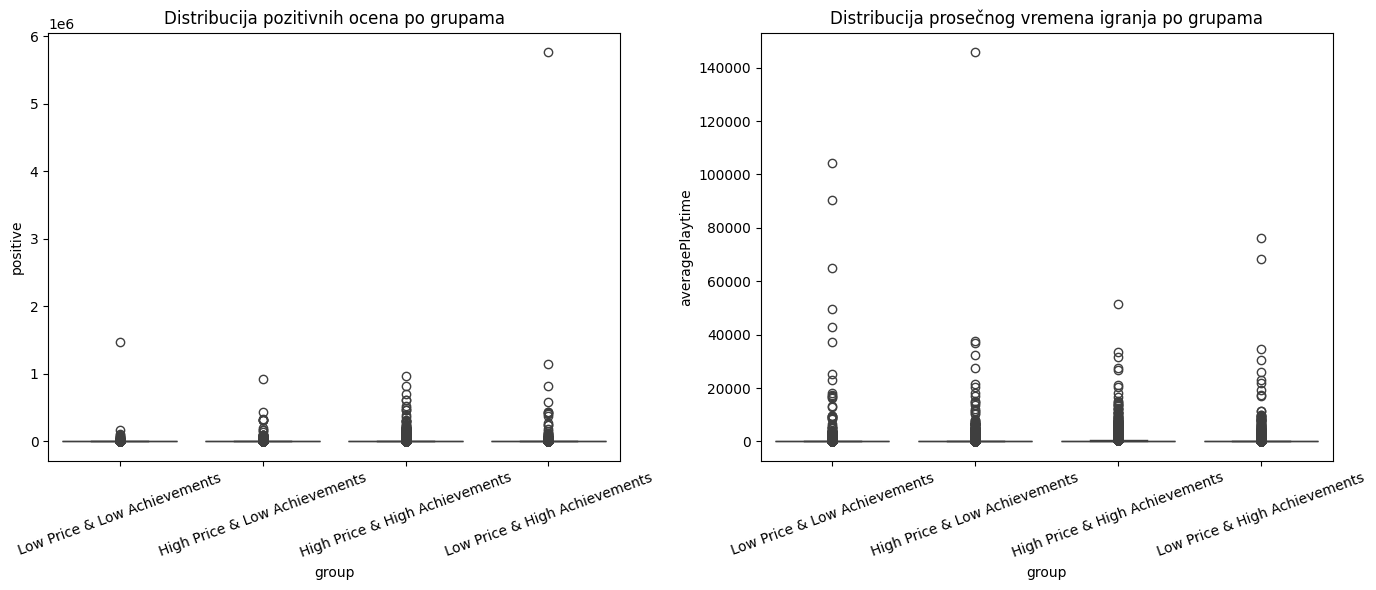

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# prebacimo u Pandas za lakšu vizualizaciju
pdf = df_clean.select("price", "achievements", "positive", "averagePlaytime").toPandas()

# null vrednosti da ne smetaju
pdf = pdf.dropna(subset=["price", "achievements", "positive", "averagePlaytime"])

# podela po medijanama
price_median = pdf["price"].median()
ach_median = pdf["achievements"].median()

pdf["price_group"] = pdf["price"].apply(lambda x: "High Price" if x > price_median else "Low Price")
pdf["ach_group"] = pdf["achievements"].apply(lambda x: "High Achievements" if x > ach_median else "Low Achievements")

# kombinovana grupa
pdf["group"] = pdf["price_group"] + " & " + pdf["ach_group"]

# vizuelizacija
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.boxplot(data=pdf, x="group", y="positive", ax=axes[0])
axes[0].set_title("Distribucija pozitivnih ocena po grupama")
axes[0].tick_params(axis='x', rotation=20)

sns.boxplot(data=pdf, x="group", y="averagePlaytime", ax=axes[1])
axes[1].set_title("Distribucija prosečnog vremena igranja po grupama")
axes[1].tick_params(axis='x', rotation=20)

plt.tight_layout()
plt.show()


2.75 :) anova za ovo iznad

In [ ]:
import scipy.stats as stats

# grupni proseci
group_means = pdf.groupby("group")[["positive", "averagePlaytime"]].mean()
print(group_means)

# ANOVA za positive
anova_positive = stats.f_oneway(
    pdf[pdf["group"]=="High Price & High Achievements"]["positive"],
    pdf[pdf["group"]=="Low Price & High Achievements"]["positive"],
    pdf[pdf["group"]=="High Price & Low Achievements"]["positive"],
    pdf[pdf["group"]=="Low Price & Low Achievements"]["positive"]
)

# ANOVA za playtime
anova_playtime = stats.f_oneway(
    pdf[pdf["group"]=="High Price & High Achievements"]["averagePlaytime"],
    pdf[pdf["group"]=="Low Price & High Achievements"]["averagePlaytime"],
    pdf[pdf["group"]=="High Price & Low Achievements"]["averagePlaytime"],
    pdf[pdf["group"]=="Low Price & Low Achievements"]["averagePlaytime"]
)

print("ANOVA Positive:", anova_positive)
print("ANOVA Playtime:", anova_playtime)

                                   positive  averagePlaytime
group                                                       
High Price & High Achievements  2942.431566       269.846618
High Price & Low Achievements    933.268780       151.519551
Low Price & High Achievements   1299.766892       106.660947
Low Price & Low Achievements     281.273118        66.551228
ANOVA Positive: F_onewayResult(statistic=np.float64(20.132605165599056), pvalue=np.float64(4.913283356698646e-13))
ANOVA Playtime: F_onewayResult(statistic=np.float64(59.03465674628279), pvalue=np.float64(4.298486172104017e-38))


Ukratko: **Free igre pokazuju tendenciju većeg broja igrača i ocena, ali samo peakCCU dolazi blizu statističke značajnosti.** Paid igre nemaju jasan "edge"

anova:
**zakljucak za test:**
- **Achievements** su glavni faktor: više achievements → više pozitivnih ocena i duže vreme igranja.
- **Cena** ima manji efekat, ali visoka cena + visoka achievements daje najveće proseke.
- ANOVA potvrđuje da su razlike između kombinacija grupa **značajne**.

# 3 TEST: Veza između kritičkih ocena i uspeha kod korisnika


Prvo da vidimo linearne veze među kolonama metacriticScore, userScore, positive, recommendations

In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation

# samo numeričke kolone koje me zanimaju
numeric_cols = ["metacriticScore", "userScore", "positive", "recommendations"]

# kreiram features vektor
assembler = VectorAssembler(inputCols=numeric_cols, outputCol="features")
df_vector = assembler.transform(df_clean.select(numeric_cols)).select("features")

# korelaciona matrica
correlation_matrix = Correlation.corr(df_vector, "features").head()[0].toArray()

# u pandas za pregled
import pandas as pd
corr_df = pd.DataFrame(correlation_matrix, columns=numeric_cols, index=numeric_cols)
print("Korelaciona matrica:")
print(corr_df)

Korelaciona matrica:
                 metacriticScore  userScore  positive  recommendations
metacriticScore         1.000000  -0.002081  0.119939         0.124428
userScore              -0.002081   1.000000 -0.000800        -0.000669
positive                0.119939  -0.000800  1.000000         0.896510
recommendations         0.124428  -0.000669  0.896510         1.000000


Linearna regresija (positive ~ metacriticScore + userScore)

Koeficijenti modela: [192.8264290514303,-7.684119985581777]
Intercept: 351.0340492243378
R2: 0.014385647142486913
RMSE: 25472.732991841


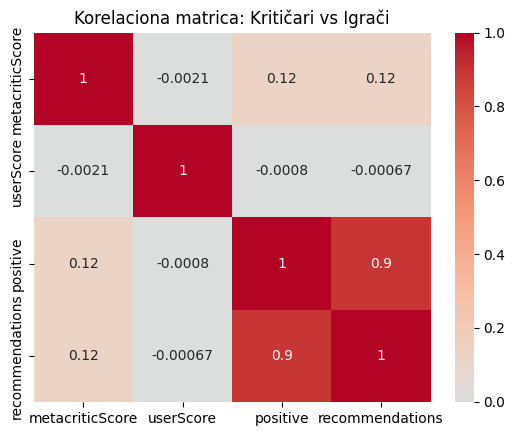

In [ ]:
from pyspark.ml.regression import LinearRegression
import seaborn as sns
import matplotlib.pyplot as plt

# features vektor za regresiju
assembler = VectorAssembler(inputCols=["metacriticScore", "userScore"], outputCol="features")
df_reg = assembler.transform(df_clean).select("features", "positive")

# kreiram model
lr = LinearRegression(featuresCol="features", labelCol="positive")

# fitujem model
lr_model = lr.fit(df_reg)

# rez modela
print("Koeficijenti modela:", lr_model.coefficients)
print("Intercept:", lr_model.intercept)
print("R2:", lr_model.summary.r2)
print("RMSE:", lr_model.summary.rootMeanSquaredError)

# vizuelno
sns.heatmap(corr_df, annot=True, cmap="coolwarm", center=0)
plt.title("Korelaciona matrica: Kritičari vs Igrači")
plt.show()


**Zaključak:** Hipoteza je delimično potvrđena samo za `positive` i `recommendations`, dok `userScore` ne prati kritičare.

# 4. TEST: Da li duže igrane igre dobijaju više preporuka?
*Hipoteza:* Postoji pozitivna veza između averagePlaytime i recommendations (odnosno što se više igra → više ljudi preporučuje).

korelacija

In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
import pandas as pd

numeric_cols = ["averagePlaytime", "recommendations"]

assembler = VectorAssembler(inputCols=numeric_cols, outputCol="features")
df_vector = assembler.transform(df_clean.select(numeric_cols)).select("features")

correlation_matrix = Correlation.corr(df_vector, "features").head()[0].toArray()
corr_df = pd.DataFrame(correlation_matrix, columns=numeric_cols, index=numeric_cols)

print("Korelaciona matrica:\n", corr_df)


Korelaciona matrica:
                  averagePlaytime  recommendations
averagePlaytime         1.000000         0.183478
recommendations         0.183478         1.000000


Scatterplot sa regresionom linijom

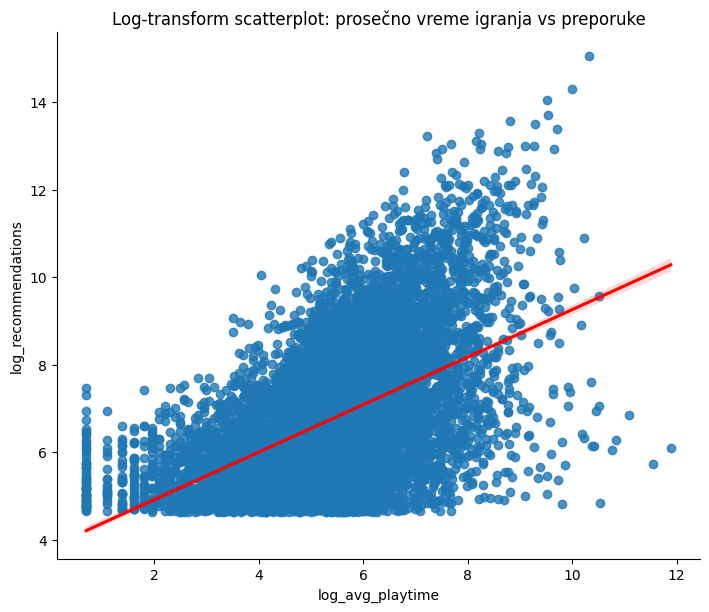

In [ ]:
import numpy as np

pdf["log_avg_playtime"] = np.log1p(pdf["averagePlaytime"])  # log(1 + x) da se izbegne log(0)
pdf["log_recommendations"] = np.log1p(pdf["recommendations"])

sns.lmplot(data=pdf, x="log_avg_playtime", y="log_recommendations", line_kws={"color":"red"}, height=6, aspect=1.2)
plt.title("Log-transform scatterplot: prosečno vreme igranja vs preporuke")
plt.show()


**Zaključak:**  
Hipoteza je **delimično potvrđena** – više igrane igre imaju tendenciju da dobiju više preporuka, ali efekat nije presudan i preporuke zavise i od drugih faktora (npr. žanr, kvalitet, cena, ocene korisnika).

# 5. TEST: Predikcija preporuka (`recommendations`)

In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

# prediktorske kolone koje nemaju null vrednosti
feature_cols = [
    'price', 'discount', 'dlcCount',
    'supportWindows', 'supportMac', 'supportLinux',
    'metacriticScore', 'userScore', 'positive', 'negative',
    'achievements', 'averagePlaytime'
]

# ciljna kolona
target_col = 'recommendations'

# kreiranje feature vektora
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
df_ml = assembler.transform(df_clean).select("features", target_col)

# deljenje na train i test set
train_data, test_data = df_ml.randomSplit([0.7, 0.3], seed=42)

test_data_filtered = test_data.filter(col("recommendations") > 0)

print(f"Train rows: {train_data.count()}, Test rows: {test_data_filtered.count()}")

# kreiranje i treniranje Random Forest modela
rf = RandomForestRegressor(featuresCol="features", labelCol=target_col, numTrees=50, maxDepth=10, seed=42)

# fitovanje modela na trening podacima
rf_model = rf.fit(train_data)

# predikcija na setu
predictions = rf_model.transform(test_data_filtered)
predictions.select("features", target_col, "prediction").show(5)

# evaluacija modela
evaluator_r2 = RegressionEvaluator(labelCol=target_col, predictionCol="prediction", metricName="r2")
evaluator_rmse = RegressionEvaluator(labelCol=target_col, predictionCol="prediction", metricName="rmse")

r2 = evaluator_r2.evaluate(predictions)
rmse = evaluator_rmse.evaluate(predictions)

print(f"R2: {r2:.4f}")
print(f"RMSE: {rmse:.2f}")



Train rows: 53514, Test rows: 3972
+--------------------+---------------+------------------+
|            features|recommendations|        prediction|
+--------------------+---------------+------------------+
|(12,[0,2,3,4,5],[...|          202.0| 8.482952436595678|
|(12,[0,2,3,4,5,10...|          104.0|17.875449679217926|
|(12,[0,2,3,4,5,10...|          187.0|14.813979580918835|
|(12,[0,2,3,4,5,10...|          118.0|18.477151932409605|
|(12,[0,2,3,4,5,10...|          219.0| 11.00254291711948|
+--------------------+---------------+------------------+
only showing top 5 rows

R2: -0.1714
RMSE: 48362.51


price: 0.2052
discount: 0.0000
dlcCount: 0.1761
supportWindows: 0.0000
supportMac: 0.0497
supportLinux: 0.1046
metacriticScore: 0.0692
userScore: 0.0000
positive: 0.0919
negative: 0.0492
achievements: 0.1653
averagePlaytime: 0.0889


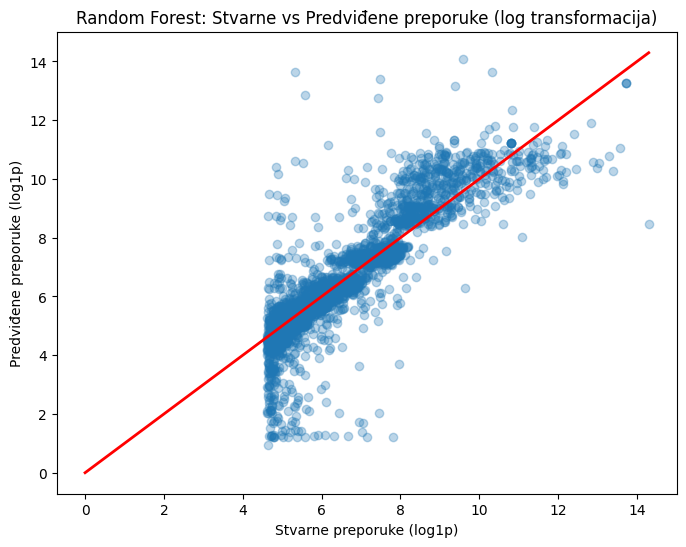

In [ ]:
# feature Importances (što model smatra važnim)
importances = rf_model.featureImportances
for col_name, importance in zip(feature_cols, importances):
    print(f"{col_name}: {importance:.4f}")

import matplotlib.pyplot as plt

pdf_pred = predictions.select(target_col, "prediction").toPandas()

plt.figure(figsize=(8,6))
plt.scatter(np.log1p(pdf_pred[target_col]), np.log1p(pdf_pred["prediction"]), alpha=0.3)
plt.plot([0, np.log1p(pdf_pred[target_col].max())],
         [0, np.log1p(pdf_pred[target_col].max())],
         color='red', linewidth=2)
plt.xlabel("Stvarne preporuke (log1p)")
plt.ylabel("Predviđene preporuke (log1p)")
plt.title("Random Forest: Stvarne vs Predviđene preporuke (log transformacija)")
plt.show()

**Zaključak**
    - Model je jednostavan random forest i ne predviđa ekstremne vrednosti dobro.
    - Međutim, **feature importances daju dobar uvid u to šta generalno utiče na broj preporuka**: skuplje igre sa više dodataka i dostignuća imaju tendenciju da dobiju više preporuka.
    - Vizuelizacija bez log-transformacije jasno pokazuje da su većina preporuka male vrednosti, a ekstremi „izvlače“ RMSE.

# STRIMING simulacija :(

Total rows: 76638, Batch size: 20000, Number of batches: 4

Processing batch 1/4 (rows 0 to 20000)


/tmp/ipython-input-1598927900.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=agg_df.sort_values("count", ascending=False), x="genre", y="count", palette="tab20")


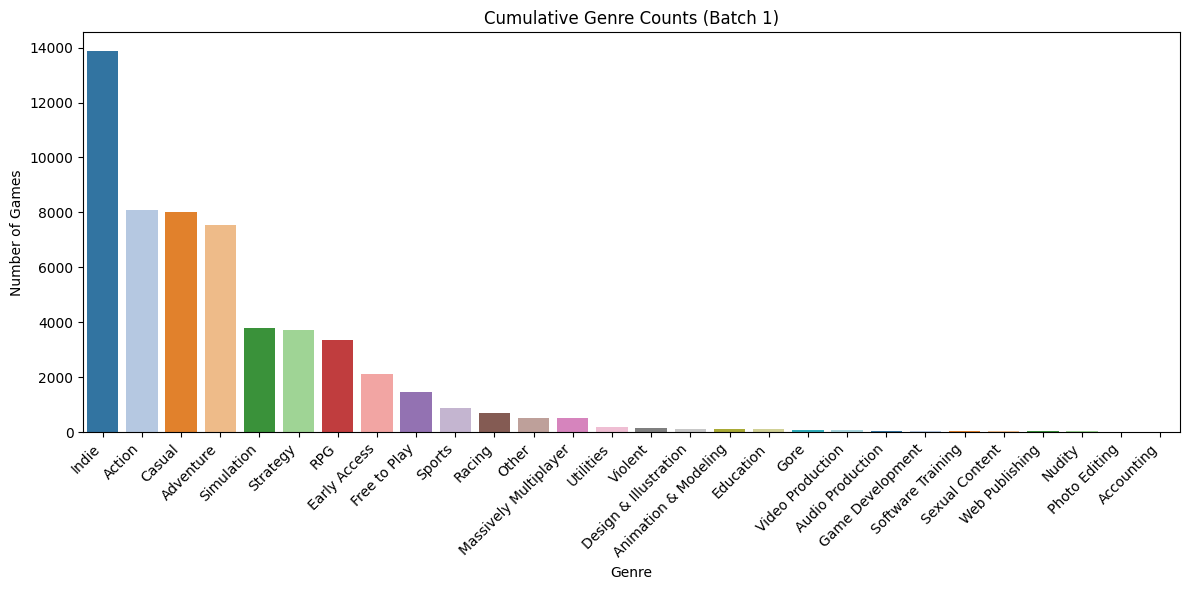


Processing batch 2/4 (rows 20000 to 40000)


/tmp/ipython-input-1598927900.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=agg_df.sort_values("count", ascending=False), x="genre", y="count", palette="tab20")


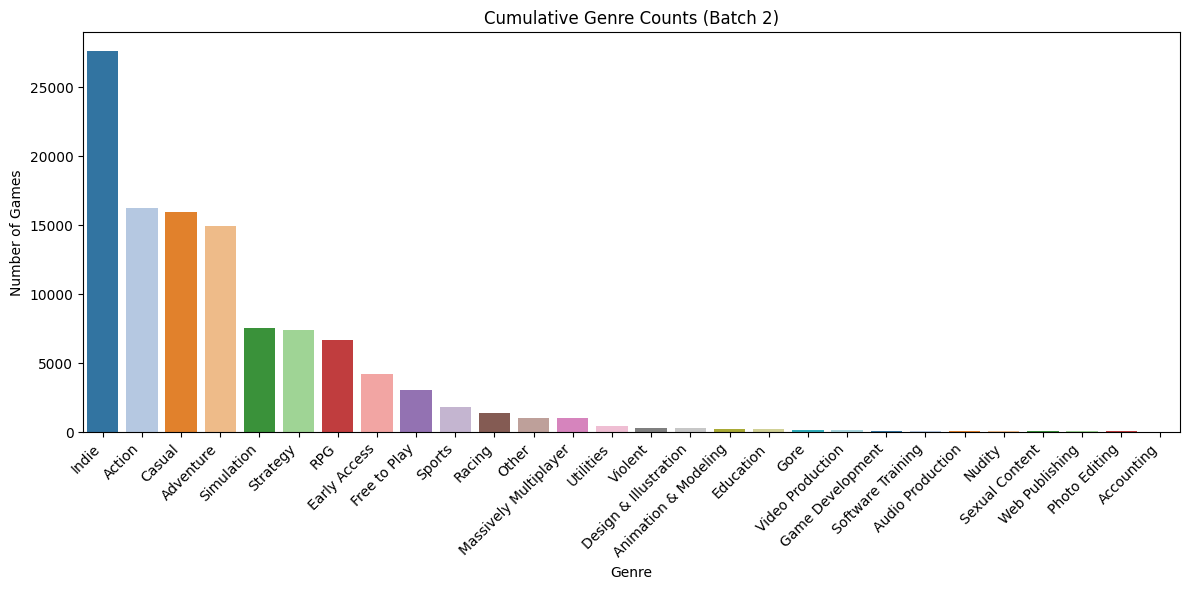


Processing batch 3/4 (rows 40000 to 60000)


/tmp/ipython-input-1598927900.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=agg_df.sort_values("count", ascending=False), x="genre", y="count", palette="tab20")


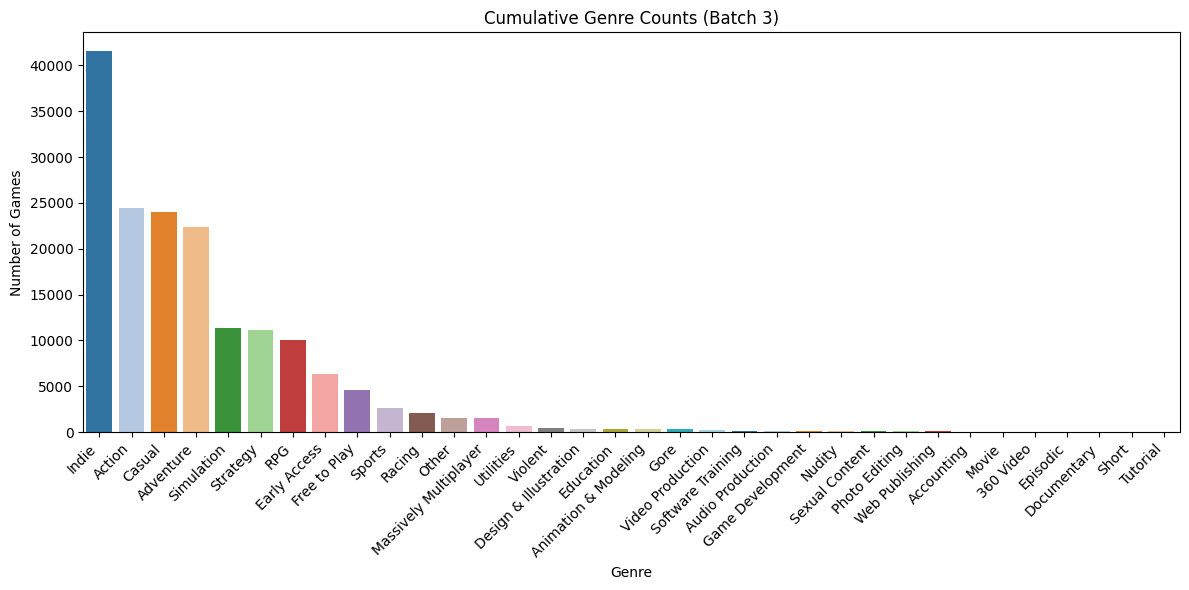


Processing batch 4/4 (rows 60000 to 80000)


/tmp/ipython-input-1598927900.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=agg_df.sort_values("count", ascending=False), x="genre", y="count", palette="tab20")


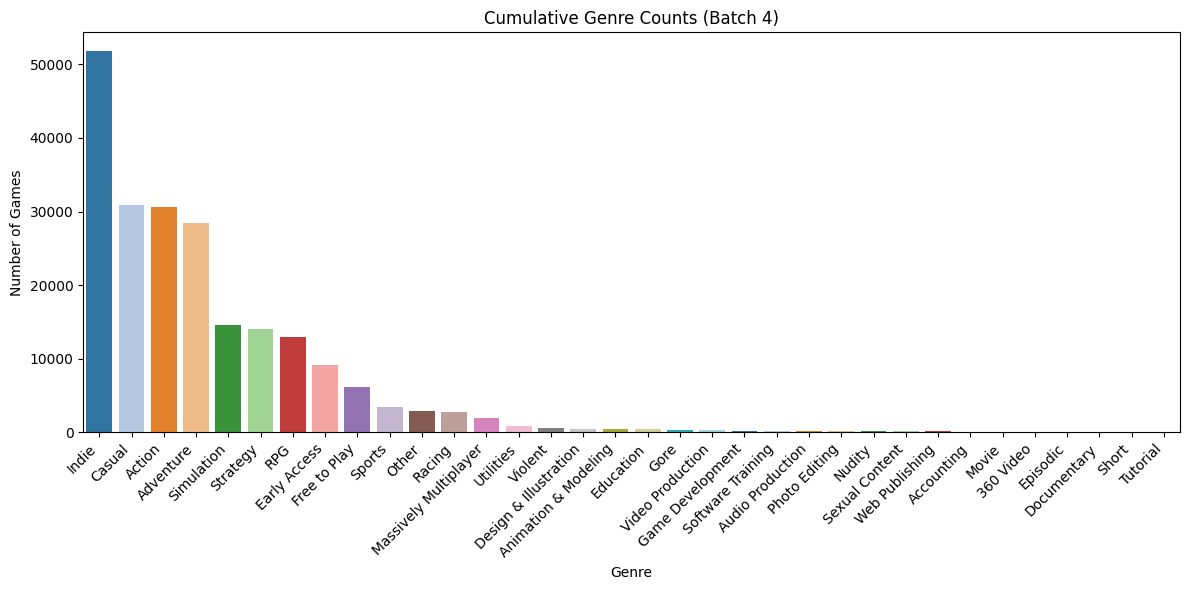

In [ ]:
from pyspark.sql.functions import explode, split, col
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import time

# simulacija streaminga sa batchevima
batch_size = 2000
total_rows = df_clean.count()
num_batches = (total_rows // batch_size) + 1

print(f"Total rows: {total_rows}, Batch size: {batch_size}, Number of batches: {num_batches}")

# prazan DataFrame za agregaciju
agg_df = pd.DataFrame(columns=["genre", "count"])

# iteracija po batchevima
for i in range(num_batches):
    start_idx = i * batch_size
    end_idx = start_idx + batch_size
    print(f"\nProcessing batch {i+1}/{num_batches} (rows {start_idx} to {end_idx})")

    # uzmi batch iz df_clean
    batch = df_clean.limit(end_idx).subtract(df_clean.limit(start_idx))

    # explode genres po igri (ako ih ima više od jednog)
    batch_exploded = batch.withColumn("genre", explode(split(col("genres"), ",")))

    # grupisanje po žanru i brojanje
    batch_count = batch_exploded.groupBy("genre").count().toPandas()

    # dodavanje u ukupnu agregaciju (simulacija kumulativnog stream-a)
    if not agg_df.empty:
        agg_df = pd.merge(agg_df, batch_count, on="genre", how="outer", suffixes=("_old", "_new"))
        agg_df["count"] = agg_df[["count_old", "count_new"]].fillna(0).sum(axis=1)
        agg_df = agg_df[["genre", "count"]]
    else:
        agg_df = batch_count

    # vizuelizacija
    plt.figure(figsize=(12,6))
    sns.barplot(data=agg_df.sort_values("count", ascending=False), x="genre", y="count", palette="tab20")
    plt.xticks(rotation=45, ha='right')
    plt.title(f"Cumulative Genre Counts (Batch {i+1})")
    plt.ylabel("Number of Games")
    plt.xlabel("Genre")
    plt.tight_layout()
    plt.show()

    # pauza da se simulira streaming
    time.sleep(1)